In [1]:
# %load cal_myEnergyBudget.py
from xmitgcm import open_mdsdataset
import xgcm
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import pandas as pd
import numpy as np
import math
from scipy import integrate
import xarray as xr
import string

import os, psutil
process = psutil.Process(os.getpid())
print(process.memory_info().rss) 

140050432


In [2]:
currentDirectory = os.getcwd()
data_dir = currentDirectory[:-7] + '/input/'
print(data_dir)

/scratch/jxchang/HighRes1/results/TideU008N0LinH200ho140Ah0200Cdqdt003/input/


In [3]:
ds1 = open_mdsdataset(data_dir, geometry='cartesian', endian='<',prefix=['energyvars','statevars','statevars2d'])
ds2 = open_mdsdataset(data_dir, geometry='cartesian', endian='<',prefix=['energymvars'])
t = 0
grid = xgcm.Grid(ds1, periodic=False)
print(grid)

<xgcm.Grid>
T Axis (not periodic, boundary=None):
  * center   time
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center


In [4]:
f0 = 1.e-4
g = 9.8
rhoNil=999.8
rhoConst=rhoNil

om=2*np.pi/12.4/3600
alpha = 2e-4
beta = 0e-4
nz = 200
#dz=H/nz 

In [5]:
xmin = 34000
xmax = 50000
numcolt=21
numcolv=21
                                        
ttlen=len(ds1.time)
print('the length of time:' + str(ttlen) )

time1=ds1.coords['time']
time2=ds2.coords['time']
xc=ds1.coords['XC']
xg=ds1.coords['XG']
yc=ds1.coords['YC']
yg=ds1.coords['YG']
z=ds1.coords['Z']

the length of time:173


In [6]:
# calculate each face of pressure, velocity
PS = 0.5*(ds1['PHIHYD'].roll(YC=1).values+ds1['PHIHYD'].values) 
PW = 0.5*(ds1['PHIHYD'].roll(XC=1).values+ds1['PHIHYD'].values)

#print(np.shape(PS))
#print('PHIHYD=' + str(ds1['PHIHYD'].isel(YC=0,time=100,Z=2).values))
#print('PS='+ str(PS[100,2,0,:]))
print('PW='+ str(PW[35,:,0,1]))
#print(ds1['PHIHYD'].roll(XC=1)+ds1['PHIHYD'])
#print(ds1['PHIHYD'].roll(XC=1).values[100,2,0,:])
#print(ds1['PHIHYD'].values[100,2,0,:])

#when use interp-> can't with .values???  can't work
#US=xr.DataArray(ds1['UVEL'].interp(XG=xc,YC=yg,kwargs={'fill_value':'extrapolate'}).data,coords=[time1,z,yg,xc],dims=['time','Z','YG','XC'])
#print(US.values)
#VW=(ds1['VVEL'].interp(XC=xg,YG=yc, kwargs={'fill_value': 'None'})).values()

# this US.VW.UC.VC only correct in 2d cases
US=0.5*(ds1['UVEL'].roll(XG=-1).values+ds1['UVEL'].values)
VW=0.5*(ds1['VVEL'].roll(XC=1).values+ds1['VVEL'].values) #VW(when X=0, incorrec
UC=US
VC=ds1['VVEL'].values

#print('U:' + str(ds1['UVEL'].isel(YC=0,time=100,Z=2).values))
#print('US:' +str(US[100,2,0,:]))
#print('V:' +str(ds1['VVEL'].isel(YG=0,time=100,Z=2).values))
#print('VW:' + str(VW[100,2,0,:]))

/home/jxchang/jupyter_py3.7/lib/python3.7/site-packages/xarray/core/dataarray.py:3128: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


PW=[0.15596013 0.41172682 0.59362574 0.75308743 0.90223891 1.04430227
 1.18383525 1.32090822 1.45515049 1.58659187 1.71513917 1.84168089
 1.96674166 2.08965466 2.21039938 2.32977995 2.44867296 2.56727292
 2.68558708 2.80361269 2.92136836 3.03894425 3.15638409 3.27375237
 3.39108222 3.50838292 3.62556712 3.7426392  3.85968989 3.97672348
 4.09372582 4.21069308 4.32760569 4.44443785 4.56118953 4.67786075
 4.7944515  4.91096179 5.02739161 5.14374096]


In [7]:
# depth mean pressure
P0S=np.sum(PS*(ds1['drF']*ds1['hFacS']).values,axis=1)
P0W=np.sum(PW*(ds1['drF']*ds1['hFacW']).values,axis=1)
P0C=np.sum((ds1['PHIHYD']*ds1['drF']*ds1['hFacC']).values,axis=1)
#print('P0W=' +str(P0W[100,0,:]))
#print(np.shape(P0W))
print(P0S[35,50,721])
print(P0W[35,50,721])
print(P0C[35,50,721])

-6.003706256537363
-6.510284040857347
-5.992857834101871


In [8]:
# depth mean velocity
U0W=((ds1['UVEL']*ds1['drF']*ds1['hFacW']).sum('Z')).values
U0S= np.sum(US*(ds1['drF']*ds1['hFacS']).values,axis=1)
U0C= np.sum(UC*(ds1['drF']*ds1['hFacS']).values,axis=1)
V0W= np.sum(VW*(ds1['drF']*ds1['hFacW']).values,axis=1)
V0S=((ds1['VVEL']*ds1['drF']*ds1['hFacS']).sum('Z')).values
V0C= np.sum(UC*(ds1['drF']*ds1['hFacS']).values,axis=1)
#print(np.shape(U0W))
#print(np.shape(U0S))
print(U0C[35,50,721])

-27.132427307890712


In [9]:
print(np.shape(U0W))
print(np.shape(U0S))

(173, 120, 1440)
(173, 120, 1440)


In [10]:
print(U0W[35,50,721])
print(U0S[35,50,721])

-27.443301323038696
-27.132427307890712


In [11]:
# depth
ZW=((ds1['drF']*ds1['hFacW']).sum('Z')).values
ZS=((ds1['drF']*ds1['hFacS']).sum('Z')).values
ZC=((ds1['drF']*ds1['hFacC']).sum('Z')).values
print(np.shape(ZW))
#print('ZW=' +str(ZW[0,:]))
print(ZC[50,721])
print(ZW[50,721])
print(ZS[50,721])

(120, 1440)
56.17708333333334
56.09375
55.5


In [12]:
print(ZC[100,721])
print(ZW[100,721])
print(ZS[100,721])

0.0
0.0
0.0


In [13]:
# divide depth
for j in range(len(yc)):
    for i in range(len(xc)):
        if ZW[j,i]!=0:
            P0W[:,j,i]=P0W[:,j,i]/ZW[j,i]
        else:
            P0W[:,j,i]=0

    #print(P0W[100,0,:])

    for i in range(len(xc)):
        if ZS[j,i]!=0:
            P0S[:,j,i]=P0S[:,j,i]/ZS[j,i]
        else:
            P0S[:,j,i]=0
            
    for i in range(len(xc)):
        if ZC[j,i]!=0:
            P0C[:,j,i]=P0C[:,j,i]/ZC[j,i]
        else:
            P0C[:,j,i]=0
    #print(P0S[100,0,:])
    #print(U0W[100,0,:])


In [14]:
print(P0C[35,50,721])
print(P0W[35,50,721])
print(P0S[35,50,721])

-0.10667798110027434
-0.11606077398742903
-0.10817488750517772


In [15]:
for j in range(len(yc)):
    for i in range(len(xc)):
        if ZW[j,i]!=0:
            U0W[:,j,i]=U0W[:,j,i]/ZW[j,i]
            V0W[:,j,i]=V0W[:,j,i]/ZW[j,i]
        else:
            U0W[:,j,i]=0
            V0W[:,j,i]=0

    for i in range(len(xc)):
        if ZS[j,i]!=0:
            U0S[:,j,i]=U0S[:,j,i]/ZS[j,i]
            V0S[:,j,i]=V0S[:,j,i]/ZS[j,i]
        else:
            U0S[:,j,i]=0
            V0S[:,j,i]=0

    for i in range(len(xc)):
        if ZC[j,i]!=0:
            U0C[:,j,i]=U0C[:,j,i]/ZC[j,i]
            V0C[:,j,i]=V0C[:,j,i]/ZC[j,i]
        else:
            U0C[:,j,i]=0
            V0C[:,j,i]=0
    #SIZE OF DEPTH MEAN VARIABLE:(TIME,Y,X)
    

In [16]:
print(U0C[35,100,721])
print(U0W[35,100,721])
print(U0S[35,100,721])

0.0
0.0
0.0


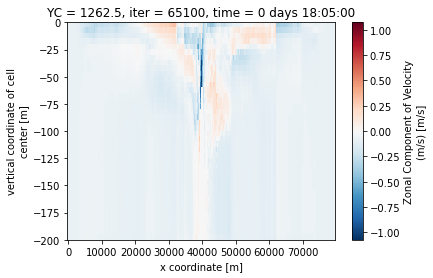

In [17]:
ds1['UVEL'].isel(time=35,YC=50).plot()

In [18]:
ds1['PS']=xr.DataArray(PS,coords=[time1,z,yg,xc],dims=['time','Z','YG','XC'])
ds1['PW']=xr.DataArray(PW,coords=[time1,z,yc,xg],dims=['time','Z','YC','XG'])
ds1['P0S']=xr.DataArray(P0S,coords=[time1,yg,xc],dims=['time','YG','XC'])
ds1['P0W']=xr.DataArray(P0W,coords=[time1,yc,xg],dims=['time','YC','XG'])


In [19]:
ds1['U0S']=xr.DataArray(U0S,coords=[time1,yg,xc],dims=['time','YG','XC'])
ds1['U0W']=xr.DataArray(U0W,coords=[time1,yc,xg],dims=['time','YC','XG'])
ds1['U0C']=xr.DataArray(U0C,coords=[time1,yc,xc],dims=['time','YC','XC'])
ds1['V0S']=xr.DataArray(V0S,coords=[time1,yg,xc],dims=['time','YG','XC'])
ds1['V0W']=xr.DataArray(V0W,coords=[time1,yc,xg],dims=['time','YC','XG'])
ds1['V0C']=xr.DataArray(V0C,coords=[time1,yc,xc],dims=['time','YC','XC'])

ds1['US']=xr.DataArray(US,coords=[time1,z,yg,xc],dims=['time','Z','YG','XC'])
ds1['UC']=xr.DataArray(UC,coords=[time1,z,yc,xc],dims=['time','Z','YC','XC'])
ds1['VW']=xr.DataArray(VW,coords=[time1,z,yc,xg],dims=['time','Z','YC','XG'])
ds1['VC']=xr.DataArray(VC,coords=[time1,z,yc,xc],dims=['time','Z','YC','XC'])

In [20]:
print(ds1['U0W'].isel(time=35,YC=100,XG=721).values)
print(ds1['U0C'].isel(time=35,YC=100,XC=721).values)
print(ds1['U0S'].isel(time=35,YG=100,XC=721).values)

0.0
0.0
0.0


In [21]:
print(ds1['UC'].isel(time=35,YC=100,XC=721).values)
print(ds1['UVEL'].isel(time=35,YC=100,XG=721).values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
print(ds1['P0W'].isel(time=35,YC=50,XG=721).values)
print(ds1['P0S'].isel(time=35,YG=50,XC=721).values)
print((ds1['PHIHYD']*ds1['drF']*ds1['hFacC']).sum('Z').isel(time=35,YC=50,XC=720).values)
print((ds1['PHIHYD']*ds1['drF']*ds1['hFacC']).sum('Z').isel(time=35,YC=50,XC=721).values)
print((ds1['PHIHYD']*ds1['drF']*ds1['hFacC']).sum('Z').isel(time=35,YC=50,XC=722).values)

-0.11606077398742903
-0.10817488750517772
-7.031525371936659
-5.992857834101871
-5.22556868053361


In [23]:
# baroclinic velocity
upW = ds1.UVEL-ds1.U0W
upC = ds1.UC-ds1.U0C
upS = ds1.US-ds1.U0S
vpS = ds1.VVEL-ds1.V0S
vpW = ds1.VW-ds1.V0W
vpC = ds1.VC-ds1.V0C

In [24]:
ds1['upS']=xr.DataArray(upS,coords=[time1,z,yg,xc],dims=['time','Z','YG','XC'])
ds1['upW']=xr.DataArray(upW,coords=[time1,z,yc,xg],dims=['time','Z','YC','XG'])
ds1['vpS']=xr.DataArray(vpS,coords=[time1,z,yg,xc],dims=['time','Z','YG','XC'])
ds1['vpW']=xr.DataArray(vpW,coords=[time1,z,yc,xg],dims=['time','Z','YC','XG'])

In [25]:
print(ds1['upW'].isel(time=35,YC=100,XG=721).values)
print(ds1['upS'].isel(time=35,YG=100,XC=721).values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [26]:
print(ds1['vpW'].isel(time=35,YC=100,XG=721).values)
print(ds1['vpS'].isel(time=35,YG=100,XC=721).values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [27]:
wC = 0.5*(ds1.WVEL+ds1.WVEL.roll(Zl=1))

/home/jxchang/jupyter_py3.7/lib/python3.7/site-packages/xarray/core/dataarray.py:3128: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs
/home/jxchang/jupyter_py3.7/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [28]:
wW = xr.DataArray(wC,coords=[time1,z,yc,xg],dims=['time','Z','YC','XG'])
wS = xr.DataArray(wC,coords=[time1,z,yg,xc],dims=['time','Z','YG','XC'])

In [29]:
print(ds1.upW)

<xarray.DataArray 'upW' (time: 173, Z: 40, YC: 120, XG: 1440)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.38777878e-17, -1.38777878e-17,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -1.38777878e-17],
         [-1.38777878e-17, -1.38777878e-17,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -1.38777878e-17],
         ...,
         [-1.38777878e-17, -1.38777878e-17,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -1.38777878e-17],
         [-1.38777878e-17, -1.38777878e-17,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -1.38777878e-17],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.38777878e-17

In [30]:
print(upW.isel(time=35,YC=100,XG=721).values)
print(upS.isel(time=35,YG=100,XC=721).values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [31]:
print(vpW.isel(time=35,YC=100,XG=721).values)
print(vpS.isel(time=35,YG=100,XC=721).values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [32]:
# baroclinic kinetic energy
kEpC = 0.5*(upC*upC+vpC*vpC + wC*wC)
kEpW = 0.5*(upW*upW+vpW*vpW + wW*wW)
kEpS = 0.5*(upS*upS+vpS*vpS + wS*wS)

hkEpW = ds1.U0W*ds1.upW+ds1.V0W*ds1.vpW
hkEpS = ds1.U0S*ds1.upS+ds1.V0S*ds1.vpS

In [33]:
print(kEpW.isel(time=35,YC=100,XG=721).values)
print(kEpS.isel(time=35,YG=100,XC=721).values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [34]:
tR_fname="../indata/TRef.bin"
tRef = np.fromfile(tR_fname)
zp1=ds1.Zp1

from scipy.interpolate import InterpolatedUnivariateSpline
rho0=(rhoNil*(1-alpha*(tRef-tRef[0])))
print('rho:'+str(rho0))
print(np.shape(rho0))
ds1['tRef'] = xr.DataArray(tRef,coords=[z],dims=['Z'])

rho:[ 999.8        1004.37837649 1005.82267008 1006.20775394 1006.66329472
 1006.78566995 1006.8696037  1006.98624331 1007.10039947 1007.2146081
 1007.33636299 1007.37812997 1007.45710888 1007.55324449 1007.63389572
 1007.66446782 1007.67364771 1007.68836113 1007.69695044 1007.711887
 1007.71895969 1007.72654518 1007.73005209 1007.73237933 1007.73318594
 1007.73475566 1007.74268512 1007.74389656 1007.74442976 1007.74529036
 1007.74697721 1007.74815143 1007.75143179 1007.75471215 1007.75799251
 1007.76127287 1007.76455322 1007.76783358 1007.77111394 1007.7743943 ]
(40,)


In [35]:
rhop=(rhoNil*(-alpha*(ds1.THETA-ds1.tRef)))
print('rhop:'+str(rhop))

rhop:<xarray.DataArray (time: 173, Z: 40, YC: 120, XC: 1440)>
dask.array<mul, shape=(173, 40, 120, 1440), dtype=float64, chunksize=(1, 40, 120, 1440), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 356.8 1.06e+03 1.745e+03 ... 7.894e+04 7.964e+04
  * YC       (YC) float64 12.5 37.5 62.5 87.5 ... 2.938e+03 2.962e+03 2.988e+03
  * Z        (Z) float64 -2.5 -7.5 -12.5 -17.5 ... -182.5 -187.5 -192.5 -197.5
    rA       (YC, XC) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    Depth    (YC, XC) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    drF      (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    PHrefC   (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    hFacC    (Z, YC, XC) float64 dask.array<chunksize=(40, 120, 1440), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(40, 120, 1440), meta=np.ndarray>
    rhoRef   (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.

In [36]:
from scipy.io import loadmat
from scipy.interpolate import interp1d

In [37]:
x = loadmat('../../../input/density_bk.mat')
rho = x['Sigr'].flatten()
id=np.argwhere(~np.isnan(rho))
rho=rho[id].flatten()
rho_s=np.sort(rho)
p = (x['grid_p'][id]*100).flatten()
TT= 35-(rho_s-1022)/alpha/1000
fT = interp1d(p,TT,fill_value='extrapolate')
T0 = fT(-z)

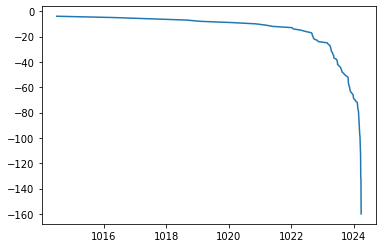

In [38]:
plt.plot(rho_s,-p)

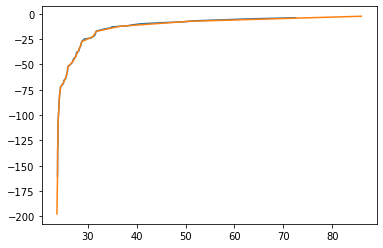

In [39]:
plt.plot(TT,-p)
plt.plot(T0,z)

In [40]:
print(T0)

[85.92201725 50.6893352  36.46354156 31.74820683 31.12493043 28.81501653
 28.48325403 27.99012809 27.52662215 26.91937388 25.94809506 25.84471572
 25.60864375 25.10060074 24.45152388 24.3347042  24.23744091 24.15855878
 24.13254726 24.06181148 24.00510399 23.96052891 23.94406631 23.92501109
 23.92105701 23.91643018 23.87768919 23.8679049  23.86387911 23.85932652
 23.85474268 23.8474674  23.8353964  23.81899132 23.80258624 23.78618117
 23.76977609 23.75337101 23.73696593 23.72056085]


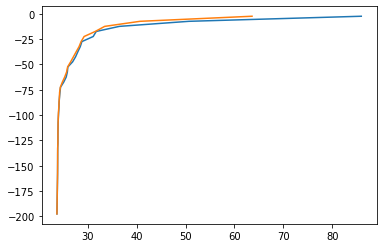

In [41]:
plt.plot(T0,z)
plt.plot(tRef,z)

In [42]:
np.amax(tRef)
np.amin(tRef)

23.712358310457375

In [43]:
s = InterpolatedUnivariateSpline(-z.values, rho0, k=1)
rhol=s(-zp1.values)
N2=g/rhoNil*np.diff(rhol)/ds1['drF'].values
print(N2)
ds1['N2'] = xr.DataArray(N2,coords=[z],dims=['Z'])

[8.97541301e-03 5.90339736e-03 1.79314853e-03 8.23976941e-04
 5.66470982e-04 2.02223253e-04 1.96601213e-04 2.26225099e-04
 2.23842265e-04 2.31290506e-04 1.60283481e-04 1.18354640e-04
 1.71646560e-04 1.73285764e-04 1.09020667e-04 3.89647436e-05
 2.34201291e-05 2.28412395e-05 2.30599671e-05 2.15733813e-05
 1.43678849e-05 1.08727269e-05 5.71861627e-06 3.07178340e-06
 2.32927161e-06 9.31106525e-06 8.95987365e-06 1.71008816e-06
 1.36619661e-06 2.49699463e-06 2.80440395e-06 4.36636217e-06
 6.43079094e-06 6.43079094e-06 6.43079094e-06 6.43079094e-06
 6.43079094e-06 6.43079094e-06 6.43079094e-06 6.43079094e-06]


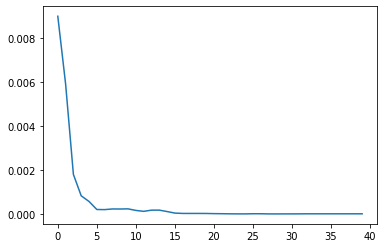

In [44]:
plt.plot(N2)

In [45]:
print(rhop)

<xarray.DataArray (time: 173, Z: 40, YC: 120, XC: 1440)>
dask.array<mul, shape=(173, 40, 120, 1440), dtype=float64, chunksize=(1, 40, 120, 1440), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 356.8 1.06e+03 1.745e+03 ... 7.894e+04 7.964e+04
  * YC       (YC) float64 12.5 37.5 62.5 87.5 ... 2.938e+03 2.962e+03 2.988e+03
  * Z        (Z) float64 -2.5 -7.5 -12.5 -17.5 ... -182.5 -187.5 -192.5 -197.5
    rA       (YC, XC) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    Depth    (YC, XC) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    drF      (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    PHrefC   (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    hFacC    (Z, YC, XC) float64 dask.array<chunksize=(40, 120, 1440), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(40, 120, 1440), meta=np.ndarray>
    rhoRef   (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array

In [46]:
Ep = g*g*rhop*rhop
Ep = Ep/2/rhoNil/rhoNil/ds1.N2
print(np.shape(Ep))

(173, 40, 120, 1440)


In [47]:
EpW = xr.DataArray(Ep,coords=[time1,z,yc,xg],dims=['time','Z','YC','XG'])
EpS = xr.DataArray(Ep,coords=[time1,z,yg,xc],dims=['time','Z','YG','XC'])

In [48]:
print(np.amax(kEpW.sum('Z').values))

179.65374126703045


In [49]:
print(kEpW)

<xarray.DataArray (time: 173, Z: 40, YC: 120, XG: 1440)>
dask.array<mul, shape=(173, 40, 120, 1440), dtype=float64, chunksize=(1, 40, 120, 1440), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 12.5 37.5 62.5 87.5 ... 2.938e+03 2.962e+03 2.988e+03
  * XG       (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04
  * Z        (Z) float64 -2.5 -7.5 -12.5 -17.5 ... -182.5 -187.5 -192.5 -197.5
    dyG      (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    dxC      (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    rAw      (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    drF      (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    PHrefC   (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    hFacW    (Z, YC, XG) float64 dask.array<chunksize=(40, 120, 1440), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(40, 120, 1440), meta=np.ndarray>
    maskInW  (YC, XG) boo

In [50]:
print((kEpW.sum('Z')).isel(time=35,YC=110,XG=range(700,800)).values)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0041244  1.33105137 2.33956301 2.13557076 1.13680937 1.33789026
 1.14466896 0.71949556 0.59914778 0.56022283 0.52393607 0.4480024
 0.45682794 0.31776729 0.32386884 0.29954239 0.26982473 0.22861209
 0.21513672 0.19051283 0.17965795 0.18971015 0.16737264 0.17189313
 0.15601162 0.16802745 0.15268017 0.15311258 0.14490692 0.14444466
 0.13772322 0.12760708 0.12438922 0.13112882 0.12504828 0.11939167
 0.11868579 0.13553659 0.12232856 0.11878306 0.11478519 0.12948091
 0.1275612  0.13333189 0.17202122 0.17348806 0.15820489 0.16766425
 0.16310777 0.17395684 0.16729805 0.18661137 0.18283

In [51]:
print(kEpS.sum('Z').isel(time=35,YG=110,XC=range(700,740)).values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

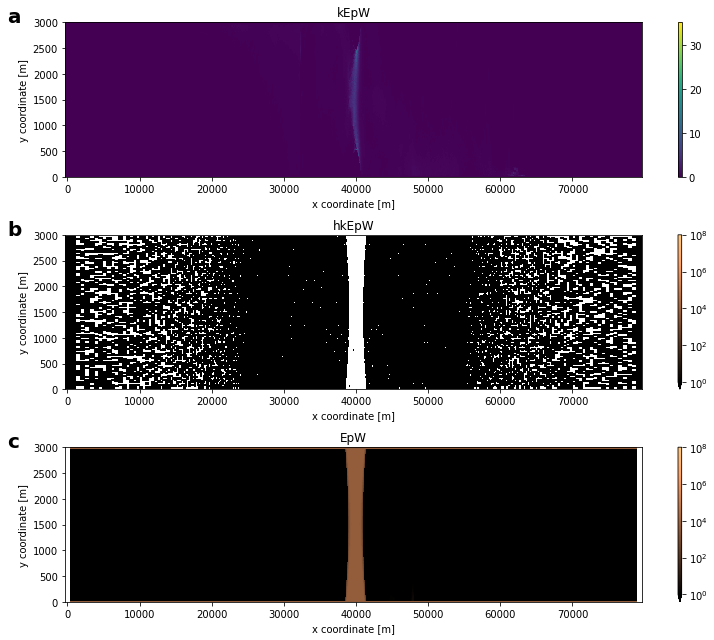

In [52]:
if 1:
    plt.clf()
    f, ax = plt.subplots(3, 1, figsize=(11,9) , sharey=True)
    
    kEpW.sum('Z').isel(time=35).plot(ax=ax[0],cbar_kwargs={"label": "", "aspect": 40})
    ax[0].set_title('kEpW')
    hkEpW.sum('Z').isel(time=35).plot(ax=ax[1],vmin=1, vmax=1e8,cmap='copper',norm=colors.LogNorm(vmin=1, vmax=1e8),cbar_kwargs={"label": "", "aspect": 40})
    ax[1].set_title('hkEpW')
    EpW.sum('Z').isel(time=35).plot(ax=ax[2],vmin=1,vmax=1e8,cmap='copper',norm=colors.LogNorm(vmin=1, vmax=1e8),cbar_kwargs={"label": "", "aspect": 40})
    ax[2].set_title('EpW')
    
    for n, axs in enumerate(ax):
        axs.text(-0.1, 1, string.ascii_lowercase[n], transform=axs.transAxes,
                size=20, weight='bold')
    plt.tight_layout()
    #plt.show()
    

<Figure size 432x288 with 0 Axes>

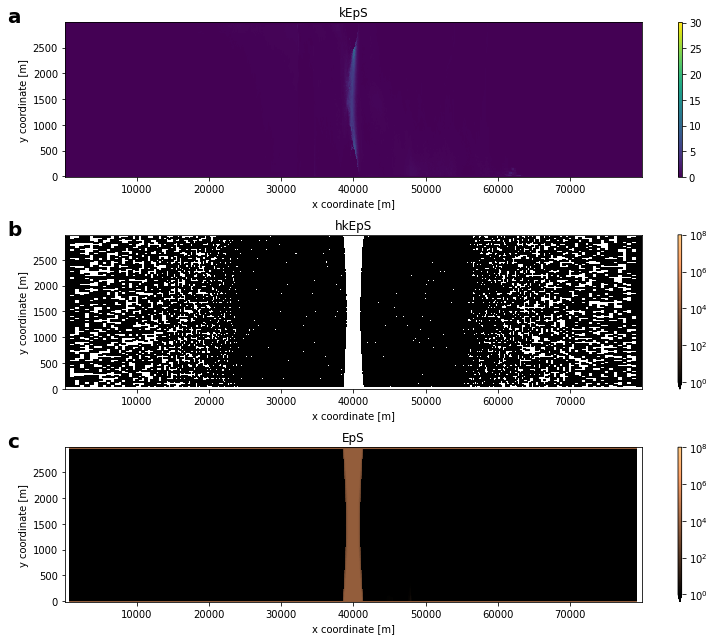

In [54]:
if 1:
    plt.clf()
    f, ax = plt.subplots(3, 1, figsize=(11,9) , sharey=True)
    
    kEpS.sum('Z').isel(time=35).plot(ax=ax[0],cbar_kwargs={"label": "", "aspect": 40})
    ax[0].set_title('kEpS')
    hkEpS.sum('Z').isel(time=35).plot(ax=ax[1],vmin=1, vmax=1e8,cmap='copper',norm=colors.LogNorm(vmin=1, vmax=1e8),cbar_kwargs={"label": "", "aspect": 40})
    ax[1].set_title('hkEpS')
    EpS.sum('Z').isel(time=35).plot(ax=ax[2],vmin=1,vmax=1e8,cmap='copper',norm=colors.LogNorm(vmin=1, vmax=1e8),cbar_kwargs={"label": "", "aspect": 40})
    ax[2].set_title('EpS')
    
    for n, axs in enumerate(ax):
        axs.text(-0.1, 1, string.ascii_lowercase[n], transform=axs.transAxes,
                size=20, weight='bold')
    plt.tight_layout()
    #plt.show()
    

In [55]:
# barotropic uE
uEbc = (ds1.UVEL*(kEpW+hkEpW+EpW)*ds1.drF*ds1.hFacW*ds1.maskW).sum('Z')
vEbc = (ds1.VVEL*(kEpS+hkEpS+EpS)*ds1.drF*ds1.hFacS*ds1.maskS).sum('Z')

process = psutil.Process(os.getpid())
print(process.memory_info().rss) 

214390894592


In [56]:
print(uEbc)

<xarray.DataArray (time: 173, YC: 120, XG: 1440)>
dask.array<sum-aggregate, shape=(173, 120, 1440), dtype=float64, chunksize=(1, 120, 1440), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 12.5 37.5 62.5 87.5 ... 2.938e+03 2.962e+03 2.988e+03
  * XG       (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04
    dyG      (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    dxC      (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    rAw      (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(120, 1440), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 00:00:00 00:31:00 ... 3 days 16:52:00


In [57]:
print(np.amax(uEbc.values))

59.70888064964543


213428744192


<Figure size 432x288 with 0 Axes>

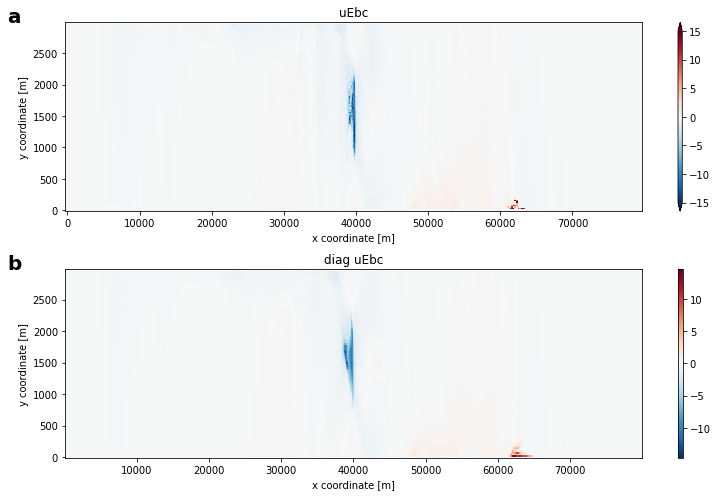

In [58]:
if 1:
    plt.clf()
    f, ax = plt.subplots(2, 1, figsize=(11,7) , sharey=True)
    
    uEbc.isel(time=35).plot(ax=ax[0],vmax=15,vmin=-15,cmap='RdBu_r',cbar_kwargs={"label": "", "aspect": 40})
    ax[0].set_title('uEbc')
    ds2['SDIAG8'].isel(time=35).plot(ax=ax[1],cbar_kwargs={"label": "", "aspect": 40})
    ax[1].set_title('diag uEbc')
    
    for n, axs in enumerate(ax):
        axs.text(-0.1, 1, string.ascii_lowercase[n], transform=axs.transAxes,
                size=20, weight='bold')
    plt.tight_layout()
    plt.savefig('./figs/myuEbc_t35.png')
    #plt.show()
    
process = psutil.Process(os.getpid())
print(process.memory_info().rss) 

In [ ]:
np.amax(ds2['SDIAG8'].values)

In [ ]:
np.amin(ds2['SDIAG8'].values)

213431713792


<Figure size 432x288 with 0 Axes>

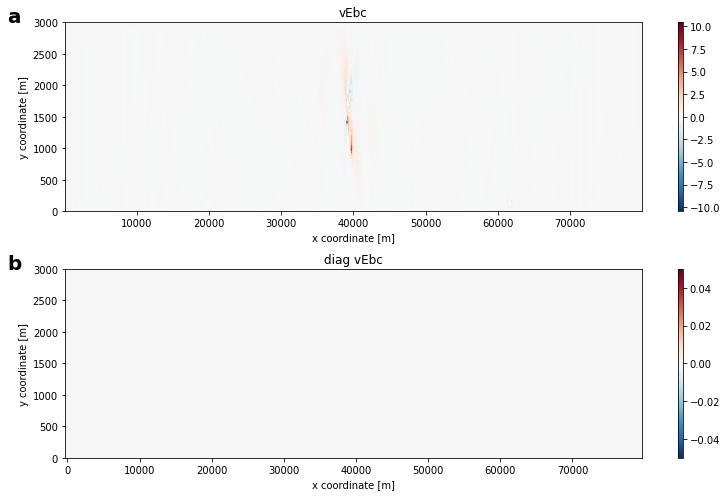

In [59]:
if 1:
    plt.clf()
    f, ax = plt.subplots(2, 1, figsize=(11,7) , sharey=True)
    
    vEbc.isel(time=35).plot(ax=ax[0],cmap='RdBu_r',cbar_kwargs={"label": "", "aspect": 40})
    ax[0].set_title('vEbc')
    ds2['SDIAG9'].isel(time=35).plot(ax=ax[1],cmap='RdBu_r',cbar_kwargs={"label": "", "aspect": 40})
    ax[1].set_title('diag vEbc')
    
    for n, axs in enumerate(ax):
        axs.text(-0.1, 1, string.ascii_lowercase[n], transform=axs.transAxes,
                size=20, weight='bold')
    plt.tight_layout()
    plt.savefig('./figs/myvEbc_t35.png')
    #plt.show()
    
process = psutil.Process(os.getpid())
print(process.memory_info().rss) 

In [60]:
time=ds2.coords['time'].values/np.timedelta64(1, 's')
time_bin_labels = np.arange(12.4*60*60/2,time[-1]-20000,12.4*60*60)
print('time_bin_labels:' +str(time_bin_labels))
time_bin = pd.timedelta_range(0, periods=8,freq='44660S')
print('time_bin:' + str(time_bin))
time_ns = pd.timedelta_range(0, periods=ttlen,freq='1860S')

time_bin_labels:[ 22320.  66960. 111600. 156240. 200880. 245520. 290160.]
time_bin:TimedeltaIndex(['0 days 00:00:00', '0 days 12:24:20', '1 days 00:48:40',
                '1 days 13:13:00', '2 days 01:37:20', '2 days 14:01:40',
                '3 days 02:26:00', '3 days 14:50:20'],
               dtype='timedelta64[ns]', freq='44660S')


In [61]:
dt=time[1]-time[0]
print('dt:' +str(dt))

dt:1860.0


In [62]:
xmin = 13000
xmax = 67000
ymin = 0
ymax = 3000

In [63]:
ix=[i for i, e in enumerate(xc) if (e > xmin) & (e < xmax)]
iy=[i for i, e in enumerate(yc) if (e > ymin) & (e < ymax)]
print(ix[0],ix[-1])
print(iy[0],iy[-1])

25 1414
0 119


In [64]:
dia_uPbc=xr.DataArray(rhoNil*ds2['SDIAG6'].data, coords=[ds2.time.values,yc,xg], dims=['time','YC','XG'])
dia_vPbc=xr.DataArray(rhoNil*ds2['SDIAG7'].data, coords=[ds2.time.values,yg,xc], dims=['time','YG','XC'])

In [65]:
dia_uEbc=xr.DataArray(rhoNil*ds2['SDIAG8'].data, coords=[ds2.time.values,yc,xg], dims=['time','YC','XG'])
dia_vEbc=xr.DataArray(rhoNil*ds2['SDIAG9'].data, coords=[ds2.time.values,yg,xc], dims=['time','YG','XC'])

<Figure size 432x288 with 0 Axes>

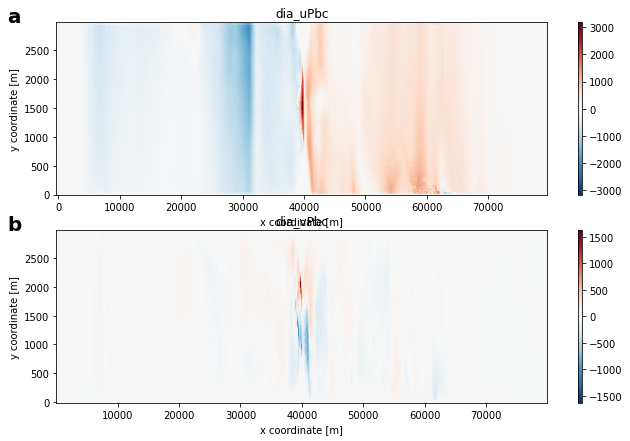

In [66]:
if 1:
    plt.clf()
    f, ax = plt.subplots(2, 1, figsize=(11,7) , sharey=True)
    
    dia_uPbc.isel(time=35).plot(ax=ax[0],cbar_kwargs={"label": "", "aspect": 40})
    ax[0].set_title('dia_uPbc')
    dia_vPbc.isel(time=35).plot(ax=ax[1],cbar_kwargs={"label": "", "aspect": 40})
    ax[1].set_title('dia_vPbc')
    
    
    for n, axs in enumerate(ax):
        axs.text(-0.1, 1, string.ascii_lowercase[n], transform=axs.transAxes,
                size=20, weight='bold')

    #plt.show()
    

In [67]:
dia_Fxbc=dia_uPbc+dia_uEbc
dia_Fybc=dia_vPbc+dia_vEbc

In [68]:
dia_ta_Fxbc=dia_Fxbc.groupby_bins('time',time_bin,labels=time_bin_labels).mean()
dia_ta_Fybc=dia_Fybc.groupby_bins('time',time_bin,labels=time_bin_labels).mean()
#print(Fbc)
dia_hd_ta_Fbc=(grid.diff(dia_ta_Fxbc*ds2['dyG'],'X',boundary='extrapolate')+grid.diff(dia_ta_Fybc*ds2['dxG'],'Y',boundary='extrapolate'))/ds2['rA']
dia_BCrad=(dia_hd_ta_Fbc*ds2['rA']).sel(XC=xc[(xc > xmin) & (xc < xmax)],YC=yc[(yc > ymin) & (yc < ymax)]).sum(['XC','YC'])/1e6
dia_fxdy=((dia_ta_Fxbc*ds2['dyG']).isel(XG=ix[-1])-(dia_ta_Fxbc*ds2['dyG']).isel(XG=ix[0])).sum('YC')/1e6


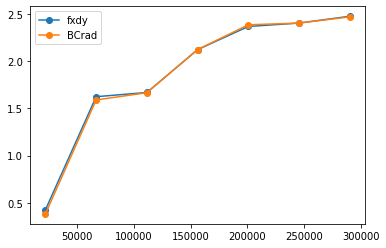

In [69]:
plt.plot(dia_fxdy.time_bins,dia_fxdy,'o-',label="fxdy")
plt.plot(dia_BCrad.time_bins,dia_BCrad,'o-',label="BCrad")
plt.legend()

In [71]:
Fxbc=dia_uPbc+uEbc
Fybc=dia_vPbc+vEbc
ta_Fxbc=Fxbc.groupby_bins('time',time_bin,labels=time_bin_labels).mean()
ta_Fybc=Fybc.groupby_bins('time',time_bin,labels=time_bin_labels).mean()
#print(Fbc)
hd_ta_Fbc=(grid.diff(ta_Fxbc*ds2['dyG'],'X',boundary='extrapolate')+grid.diff(ta_Fybc*ds2['dxG'],'Y',boundary='extrapolate'))/ds2['rA']
BCrad=(hd_ta_Fbc*ds2['rA']).sel(XC=xc[(xc > xmin) & (xc < xmax)],YC=yc[(yc > ymin) & (yc < ymax)]).sum(['XC','YC'])/1e6
fxdy=((ta_Fxbc*ds2['dyG']).isel(XG=ix[-1])-(dia_ta_Fxbc*ds2['dyG']).isel(XG=ix[0])).sum('YC')/1e6

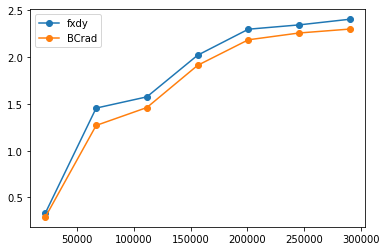

In [72]:
plt.plot(fxdy.time_bins,fxdy,'o-',label="fxdy")
plt.plot(BCrad.time_bins,BCrad,'o-',label="BCrad")
plt.legend()

In [ ]:
print(ta_Fybc.isel(YG=iy[-1]).sum('XC').values)

In [ ]:
print(ta_Fybc.isel(YG=iy[0]).sum('XC').values)

In [ ]:
print(ta_Fxbc.isel(XG=ix[-1]).sum('YC').values)

In [ ]:
print(ta_Fxbc.isel(XG=ix[0]).sum('YC').values)

In [ ]:
(-9.70649226e+08-1.16054547e+09)*25/1e6

In [ ]:
df = pd.DataFrame({"dEbt/dt": DtdEbt.values,"dia dEbt/dt": dia_DtdEbt.values})
print('df')
print(process.memory_info().rss) 
df.to_csv("TidallyAveragedMydEbtdt.csv")
print('saved csv')
print(process.memory_info().rss) 

In [ ]:
read_df = pd.read_csv("TidallyAveragedMydEbtdt.csv")

In [ ]:
print(read_df)